# IMAT 5322 BIG DATA ANALYTICS

# ASSESSMENT 1

# BY OSARETIN IGBINOBARO 

# P2685500



In [2]:
# PySpark API:
#http://spark.apache.org/docs/latest/api/python/index.html

import os
import sys
 
os.environ["SPARK_HOME"] = "/usr/spark2.4.3"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
# In below two lines, use /usr/bin/python2.7 if you want to use Python 2
os.environ["PYSPARK_PYTHON"] = "/usr/local/anaconda/bin/python" 
os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/local/anaconda/bin/python"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")


# import and define spark context
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName("appName")
sc = SparkContext(conf=conf)

import os
import sys

os.environ["SPARK_HOME"] = "/usr/spark2.4.3"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
os.environ["PYSPARK_PYTHON"] = "/usr/local/anaconda/bin/python" 
os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/local/anaconda/bin/python"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")
 
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext

from pyspark.sql import SparkSession
from functools import reduce
from pyspark.sql.functions import col, lit, when
#from graphframes import *


spark = SparkSession.builder.appName("BristishTransportPoliceData").config("spark.jars.packages", "graphframes:graphframes:0.6.0-spark2.3-s_2.11").enableHiveSupport().getOrCreate()

sqlContext = SQLContext(spark)


# Import libraries and other functions
from io import StringIO
from collections import namedtuple
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import *

import csv
import matplotlib.pyplot as plt
import gmplot
import pandas as pd
import numpy as np

In [3]:
# create a dataFrame from the csv files

btpCrimeDataDF = spark.read.option("header", "true").option("delimiter", ",")\
.option("inferSchema", "true").csv("hdfs:///user/imat5322_509225/*street.csv")

In [4]:
#Print schema to confirm that the data was imported correctly and dataframe created accordingly
btpCrimeDataDF.printSchema()

root
 |-- Crime ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)



In [5]:
#Tidy Column names by renaming the column names

btpCrimeDataDF = btpCrimeDataDF.withColumnRenamed('Crime ID', 'Crime_ID')
btpCrimeDataDF = btpCrimeDataDF.withColumnRenamed('Reported by', 'Reported_by')
btpCrimeDataDF = btpCrimeDataDF.withColumnRenamed('Falls within', 'Falls_within')
btpCrimeDataDF = btpCrimeDataDF.withColumnRenamed('LSOA code', 'LSOA_code')
btpCrimeDataDF = btpCrimeDataDF.withColumnRenamed('LSOA name', 'LSOA_name')
btpCrimeDataDF = btpCrimeDataDF.withColumnRenamed('Crime type', 'Crime_type')
btpCrimeDataDF = btpCrimeDataDF.withColumnRenamed('Last outcome category', 'Last_outcome_category')

In [6]:
#check the columns to confirm that the change took effect
btpCrimeDataDF.columns

['Crime_ID',
 'Month',
 'Reported_by',
 'Falls_within',
 'Longitude',
 'Latitude',
 'Location',
 'LSOA_code',
 'LSOA_name',
 'Crime_type',
 'Last_outcome_category',
 'Context']

In [7]:
# check for null and empty value

#from pyspark.sql.functions import isnan, when, count, col
#btpCrimeDataDF.select([count(when(isnan(x) | col(x).isNull(), x)).alias(x) for x in btpCrimeDataDF.columns]).show()


In [8]:
#declare a list variable holding the columns to delete(columns with nivalid data)
#ColumnsToDelete = ['LSOA_code',
# 'LSOA_name',]

In [9]:
#register the dataFrame as a table to enable sql queries

sqlContext.registerDataFrameAsTable(btpCrimeDataDF, "btpCrime2020_2021")

In [10]:
#a select query to confirm that the invalid data has been dropped
sqlContext.sql("select Crime_ID, LSOA_code, LSOA_name, Last_outcome_category, Context from btpCrime2020_2021").show()

+--------+---------+-----------------+---------------------+-------+
|Crime_ID|LSOA_code|        LSOA_name|Last_outcome_category|Context|
+--------+---------+-----------------+---------------------+-------+
|    null|E01031365|        Adur 002D|                 null|   null|
|    null|E01031365|        Adur 002D|                 null|   null|
|    null|E01031375|        Adur 004G|                 null|   null|
|    null|E01031375|        Adur 004G|                 null|   null|
|    null|E01031342|        Adur 008B|                 null|   null|
|    null|E01031342|        Adur 008B|                 null|   null|
|    null|E01031342|        Adur 008B|                 null|   null|
|    null|E01031342|        Adur 008B|                 null|   null|
|    null|E01019136|   Allerdale 001F|                 null|   null|
|    null|E01019114|   Allerdale 004D|                 null|   null|
|    null|E01019400|Amber Valley 001A|                 null|   null|
|    null|E01019400|Amber Valley 0

In [11]:
#To ensure good quality of the location data

from pyspark.sql import functions as fun
print("Count of invalid latitude and longitude in data")
btpCrimeDataDF.groupBy((fun.col("Longitude") == 0) &
(fun.col("Latitude") == 0)).count().show()

Count of invalid latitude and longitude in data
+------------------------------------+-----+
|((Longitude = 0) AND (Latitude = 0))|count|
+------------------------------------+-----+
|                               false|80592|
+------------------------------------+-----+



In [12]:
#print the dataFrame schema
btpCrimeDataDF.printSchema()

root
 |-- Crime_ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported_by: string (nullable = true)
 |-- Falls_within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA_code: string (nullable = true)
 |-- LSOA_name: string (nullable = true)
 |-- Crime_type: string (nullable = true)
 |-- Last_outcome_category: string (nullable = true)
 |-- Context: string (nullable = true)



In [13]:
#sql query to fetch the count of crime per year
yearlyCrime = sqlContext.sql("select substring(Month, 1, 4) as year, count(*)\
as total_crime from btpCrime2020_2021 group by year")
yearlyCrime.show()

+----+-----------+
|year|total_crime|
+----+-----------+
|2020|      39323|
|2021|      41269|
+----+-----------+



In [14]:
#importing the pixiedust for virtualization

import pixiedust

Pixiedust database opened successfully



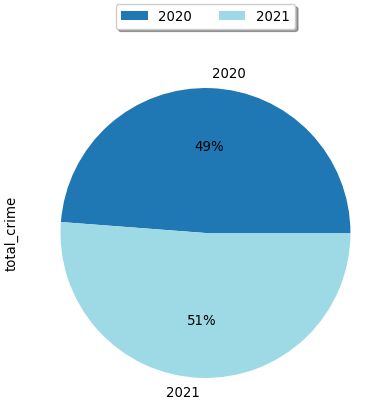

In [15]:
#display the chart
display(yearlyCrime)

In [16]:
#Get the count of crime in each month and year
sqlContext.sql("select substring(Month, 1, 4) as year, substring(Month, 6, 2) as month,\
count(*) as total from btpCrime2020_2021 group by month, year order by month, year").show(25)

+----+-----+-----+
|year|month|total|
+----+-----+-----+
|2020|   01| 5664|
|2021|   01| 2147|
|2020|   02| 5361|
|2021|   02| 2121|
|2020|   03| 4108|
|2021|   03| 2866|
|2020|   04| 1370|
|2021|   04| 3012|
|2020|   05| 1547|
|2021|   05| 3431|
|2020|   06| 2061|
|2021|   06| 3512|
|2020|   07| 2775|
|2021|   07| 3778|
|2020|   08| 3223|
|2021|   08| 3679|
|2020|   09| 3485|
|2021|   09| 3982|
|2020|   10| 3708|
|2021|   10| 4282|
|2020|   11| 3129|
|2021|   11| 4521|
|2020|   12| 2892|
|2021|   12| 3938|
+----+-----+-----+



In [17]:
#Query for the monthly crime in each year
monthlyCrime2020 = sqlContext.sql("select substring(Month, 1, 4) as year, substring(Month, 6, 2) as month_no, \
substring('JAN FEB MAR APR MAY JUN JUL AUG SEP OCT NOV DEC ', (substring(Month, 6, 2) * 4) - 3, 3) as month,\
count(*) as total from btpCrime2020_2021 WHERE substring(Month, 1, 4)=2020 group by month, year order by month_no, year")
monthlyCrime2020.show(25)

monthlyCrime2021 = sqlContext.sql("select substring(Month, 1, 4) as year, substring(Month, 6, 2) as month_no, \
substring('JAN FEB MAR APR MAY JUN JUL AUG SEP OCT NOV DEC ', (substring(Month, 6, 2) * 4) - 3, 3) as month,\
count(*) as total from btpCrime2020_2021 WHERE substring(Month, 1, 4)=2021 group by month, year order by month_no, year")
monthlyCrime2021.show(25)

+----+--------+-----+-----+
|year|month_no|month|total|
+----+--------+-----+-----+
|2020|      01|  JAN| 5664|
|2020|      02|  FEB| 5361|
|2020|      03|  MAR| 4108|
|2020|      04|  APR| 1370|
|2020|      05|  MAY| 1547|
|2020|      06|  JUN| 2061|
|2020|      07|  JUL| 2775|
|2020|      08|  AUG| 3223|
|2020|      09|  SEP| 3485|
|2020|      10|  OCT| 3708|
|2020|      11|  NOV| 3129|
|2020|      12|  DEC| 2892|
+----+--------+-----+-----+

+----+--------+-----+-----+
|year|month_no|month|total|
+----+--------+-----+-----+
|2021|      01|  JAN| 2147|
|2021|      02|  FEB| 2121|
|2021|      03|  MAR| 2866|
|2021|      04|  APR| 3012|
|2021|      05|  MAY| 3431|
|2021|      06|  JUN| 3512|
|2021|      07|  JUL| 3778|
|2021|      08|  AUG| 3679|
|2021|      09|  SEP| 3982|
|2021|      10|  OCT| 4282|
|2021|      11|  NOV| 4521|
|2021|      12|  DEC| 3938|
+----+--------+-----+-----+




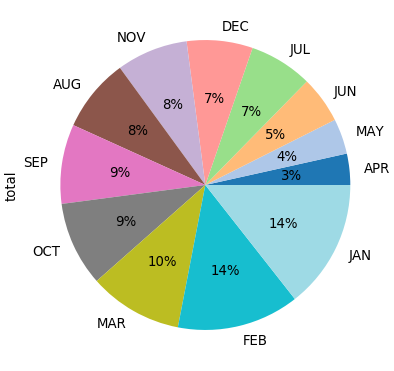

In [18]:
#display the chart
display(monthlyCrime2020)



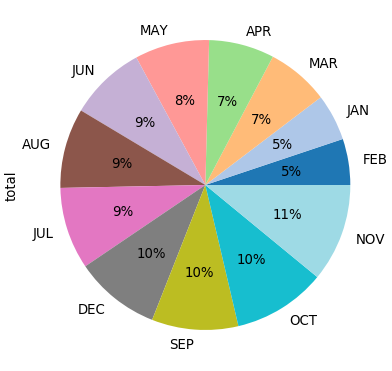

In [19]:
display(monthlyCrime2021)

In [20]:
#convert the month numbers to month names
monthlyCrime = sqlContext.sql("select substring(Month, 1, 4) as year, substring(Month, 6, 2) as month_no, \
substring('JAN FEB MAR APR MAY JUN JUL AUG SEP OCT NOV DEC ', (substring(Month, 6, 2) * 4) - 3, 3) as month,\
count(*) as total from btpCrime2020_2021 group by month, year order by month_no, year")
monthlyCrime.show(25)

+----+--------+-----+-----+
|year|month_no|month|total|
+----+--------+-----+-----+
|2020|      01|  JAN| 5664|
|2021|      01|  JAN| 2147|
|2020|      02|  FEB| 5361|
|2021|      02|  FEB| 2121|
|2020|      03|  MAR| 4108|
|2021|      03|  MAR| 2866|
|2020|      04|  APR| 1370|
|2021|      04|  APR| 3012|
|2020|      05|  MAY| 1547|
|2021|      05|  MAY| 3431|
|2020|      06|  JUN| 2061|
|2021|      06|  JUN| 3512|
|2020|      07|  JUL| 2775|
|2021|      07|  JUL| 3778|
|2020|      08|  AUG| 3223|
|2021|      08|  AUG| 3679|
|2020|      09|  SEP| 3485|
|2021|      09|  SEP| 3982|
|2020|      10|  OCT| 3708|
|2021|      10|  OCT| 4282|
|2020|      11|  NOV| 3129|
|2021|      11|  NOV| 4521|
|2020|      12|  DEC| 2892|
|2021|      12|  DEC| 3938|
+----+--------+-----+-----+



In [21]:
#virtualize the data for monthly crime
display(monthlyCrime)


In [22]:
#sqlm query to crime type count
CrimeTypeCount = sqlContext.sql("select Crime_type, substring(Month, 1, 4) as year,\
count(*) as total from btpCrime2020_2021 group by Crime_type, year")
CrimeTypeCount.show()

+--------------------+----+-----+
|          Crime_type|year|total|
+--------------------+----+-----+
|Possession of wea...|2020|  742|
|         Shoplifting|2020| 1081|
|         Other crime|2021|  398|
|Violence and sexu...|2020| 8414|
|Criminal damage a...|2021| 4625|
|               Drugs|2020| 3146|
|             Robbery|2020|  742|
|               Drugs|2021| 3080|
|        Public order|2021| 7942|
|         Other crime|2020|  400|
|Criminal damage a...|2020| 4104|
|Possession of wea...|2021|  720|
|         Other theft|2021| 4488|
|       Bicycle theft|2020| 3148|
|       Vehicle crime|2020|  879|
|         Shoplifting|2021|  887|
|       Bicycle theft|2021| 3641|
|Theft from the pe...|2021| 3329|
|       Vehicle crime|2021|  811|
|Violence and sexu...|2021|10307|
+--------------------+----+-----+
only showing top 20 rows




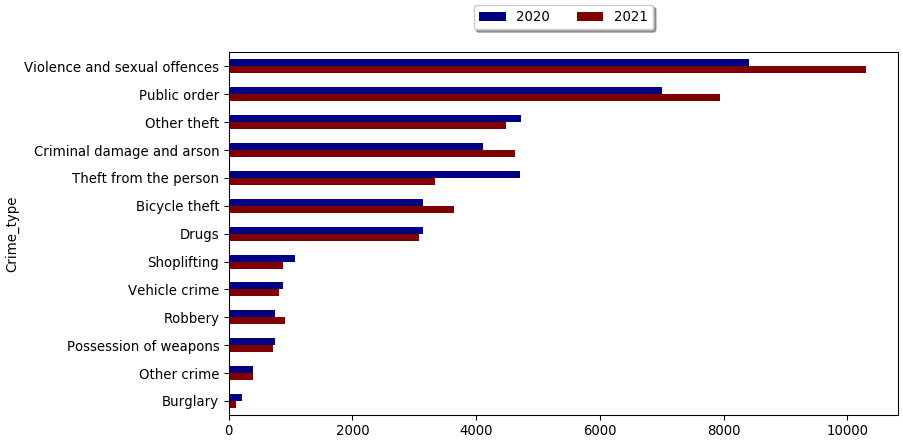

In [23]:
#display the chart
display(CrimeTypeCount)

In [24]:
#sql query to fetch crime type count by location
CrimeTypeCountByLocation = sqlContext.sql("select Crime_type, Location, substring(Month, 1, 4) as year,\
count(*) as total from btpCrime2020_2021 group by Crime_type, year, Location order by total desc limit 10")
CrimeTypeCountByLocation.show()

+--------------------+--------------------+----+-----+
|          Crime_type|            Location|year|total|
+--------------------+--------------------+----+-----+
|Violence and sexu...|On or near London...|2020|  175|
|Theft from the pe...|On or near Oxford...|2020|  164|
|Theft from the pe...|On or near Finsbu...|2020|  149|
|         Shoplifting|On or near St  Pa...|2020|  149|
|Violence and sexu...|On or near Birmin...|2021|  148|
|Theft from the pe...|On or near London...|2020|  140|
|Violence and sexu...|On or near Leeds ...|2021|  134|
|Violence and sexu...|On or near London...|2021|  132|
|Violence and sexu...|On or near Stratf...|2021|  130|
|Theft from the pe...|On or near Kings ...|2020|  123|
+--------------------+--------------------+----+-----+




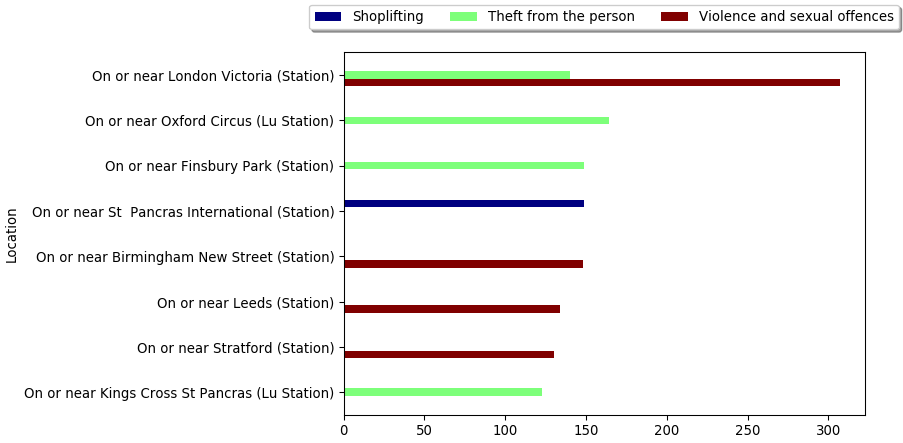

In [25]:
#visualize the data in a chart
display(CrimeTypeCountByLocation)


In [26]:
#visualise the data in a chart
display(CrimeTypeCountByLocation)

In [27]:
#sql query to fetch crime type by geolocation
CrimeByGeolocation = sqlContext.sql("select Crime_type, \
substring(Month, 0, 4) as year, Latitude, Longitude, \
count(*) as total from btpCrime2020_2021 group by year, \
Crime_type, Latitude, Longitude order by total desc")
CrimeByGeolocation.show()

+--------------------+----+---------+---------+-----+
|          Crime_type|year| Latitude|Longitude|total|
+--------------------+----+---------+---------+-----+
|Theft from the pe...|2020|51.515685|-0.141062|  164|
|Theft from the pe...|2020|51.564737|-0.105883|  149|
|         Shoplifting|2020|  51.5325| -0.12601|  149|
|Violence and sexu...|2021|52.478371|-1.898012|  148|
|Violence and sexu...|2020|53.486356|-0.134072|  145|
|Violence and sexu...|2021|53.795861|-1.543772|  134|
|Violence and sexu...|2021|53.486356|-0.134072|  132|
|Violence and sexu...|2021|51.542402|-0.002183|  130|
|Theft from the pe...|2020|51.532382|-0.120339|  123|
|Violence and sexu...|2021| 51.51906|-0.080342|  122|
|Violence and sexu...|2021| 51.50335|-0.111911|  121|
|Violence and sexu...|2020|51.542402|-0.002183|  120|
|         Other theft|2020|  51.5325| -0.12601|  118|
|Violence and sexu...|2020|52.478371|-1.898012|  117|
|Violence and sexu...|2021|53.477512|-2.226586|  115|
|Violence and sexu...|2021|5

In [46]:
#visualize the data in a map
display(CrimeByGeolocation)

In [29]:
#Average monthly crime for each year

In [30]:
aveCrime = sqlContext.sql("select Month as Date,\
substring('JAN FEB MAR APR MAY JUN JUL AUG SEP OCT NOV DEC ', (substring(Month, 6, 2) * 4) - 3, 3) as month,\
substring(Month, 0, 4) as year, substring(Month, 6, 2) as month_no, count(Crime_type) as total \
from btpCrime2020_2021 group by month, year order by month_no ASC")

aveCrime.show(24)


+-------+-----+----+--------+-----+
|   Date|month|year|month_no|total|
+-------+-----+----+--------+-----+
|2021-01|  JAN|2021|      01| 2147|
|2020-01|  JAN|2020|      01| 5664|
|2021-02|  FEB|2021|      02| 2121|
|2020-02|  FEB|2020|      02| 5361|
|2020-03|  MAR|2020|      03| 4108|
|2021-03|  MAR|2021|      03| 2866|
|2021-04|  APR|2021|      04| 3012|
|2020-04|  APR|2020|      04| 1370|
|2021-05|  MAY|2021|      05| 3431|
|2020-05|  MAY|2020|      05| 1547|
|2021-06|  JUN|2021|      06| 3512|
|2020-06|  JUN|2020|      06| 2061|
|2021-07|  JUL|2021|      07| 3778|
|2020-07|  JUL|2020|      07| 2775|
|2021-08|  AUG|2021|      08| 3679|
|2020-08|  AUG|2020|      08| 3223|
|2021-09|  SEP|2021|      09| 3982|
|2020-09|  SEP|2020|      09| 3485|
|2021-10|  OCT|2021|      10| 4282|
|2020-10|  OCT|2020|      10| 3708|
|2021-11|  NOV|2021|      11| 4521|
|2020-11|  NOV|2020|      11| 3129|
|2020-12|  DEC|2020|      12| 2892|
|2021-12|  DEC|2021|      12| 3938|
+-------+-----+----+--------

In [31]:
display(aveCrime)



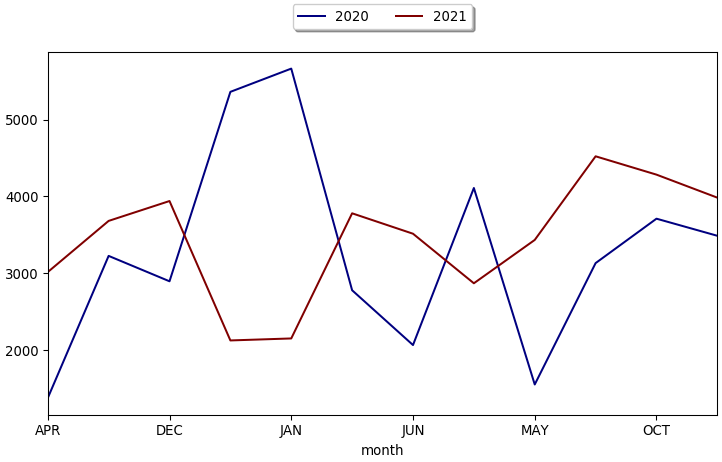

In [32]:
display(aveCrime)